In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lstm_keras
import optuna
import utils

/Users/wangzes/anaconda3/envs/time_series/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nyc_sales = pd.read_csv('nyc-property-sales.csv')
# nyc_sales.info()
# nyc_sales = nyc_sales[nyc_sales.building_class_at_time_of_sale.str.startswith('O')]
nyc_sales['sale_date'] = pd.to_datetime(nyc_sales['sale_date'], errors='coerce')
nyc_sales["month"] = nyc_sales["sale_date"].dt.to_period("M")
nyc_sales = nyc_sales[nyc_sales.sale_price > 0.0]
nyc_sales_filtered = nyc_sales[nyc_sales['building_class_at_time_of_sale'].str.startswith('A') | nyc_sales['building_class_at_time_of_sale'].str.startswith('B')]
temp = nyc_sales_filtered.groupby(
    by="month"
).agg({
    "sale_price": "sum",
    "gross_square_feet": "sum",
    "land_square_feet": "sum",
    "total_units": "sum",
    "residential_units": "sum",
    "commercial_units": "sum"
})
temp = temp.reset_index()

In [4]:
features = temp[['sale_price']].values  #  'gross_square_feet', 'residential_units', 'commercial_units'

In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(features)

sequence_length = 12  # Number of previous time steps to use for prediction
X, y = utils.create_sequences(normalized_data, sequence_length)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: lstm_keras.objective(trial, X, y, scaler), n_trials=10)

print("Best Config:", study.best_params)
print("Best Score:", study.best_value)

Best is trial 1\
Best Config: {'units': 128, 'dropout': 0.055412521529089126, 'batch_size': 32, 'epoches': 100}

In [7]:
val_predictions = study.trials[1].user_attrs['val_predictions']

In [8]:
y_pred = np.array(val_predictions).flatten()

In [10]:
y_original = temp.sale_price.to_list()

In [11]:
months = [str(period) for period in temp.month]
y_true = y_original[len(months)-len(y_pred):]

In [12]:
utils.calculate_global_metrics(y_true, y_pred)

{'MAPE': np.float64(24.12460796593417),
 'SMAPE': np.float64(12.252299404702503),
 'RMSLE': np.float64(0.17230915944140934),
 'RMSE': np.float64(243743294.4018896)}

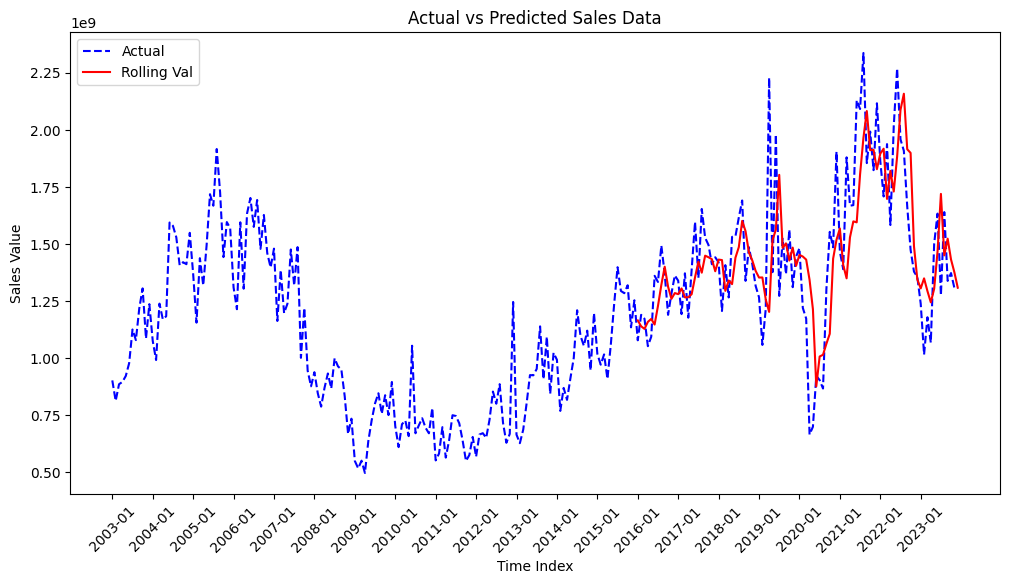

In [13]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

months = [str(period) for period in temp.month]
jan_indices = [i for i, period in enumerate(temp.month) if period.month == 1]
jan_months = [str(temp.month[i]) for i in jan_indices] 

y_original = temp.sale_price.to_list()
# Plot actual values
plt.plot(months, y_original, label='Actual', color='blue', linestyle='--')

# Plot predicted values for testing
plt.plot(months[len(months)-len(y_pred):], y_pred, label='Rolling Val', color='red')
plt.title('Actual vs Predicted Sales Data')
plt.xlabel('Time Index')
plt.ylabel('Sales Value')
plt.xticks(ticks=jan_indices, labels=jan_months, rotation=45)
plt.legend()
plt.show()